# Hyperparameters and validation sets

## Prerequisites
- [Bias, variance and generalisation]()
- [Gradient based optimisation]()

## Learning objectives
- understand what hyperparameters are
- understand what validation sets are, why we need them and how we use them

Start by running the code cell below. It will create a random polynomial function which we will try to model, and also sample some data from it which will be examples in our dataset which we can train and test our model on.

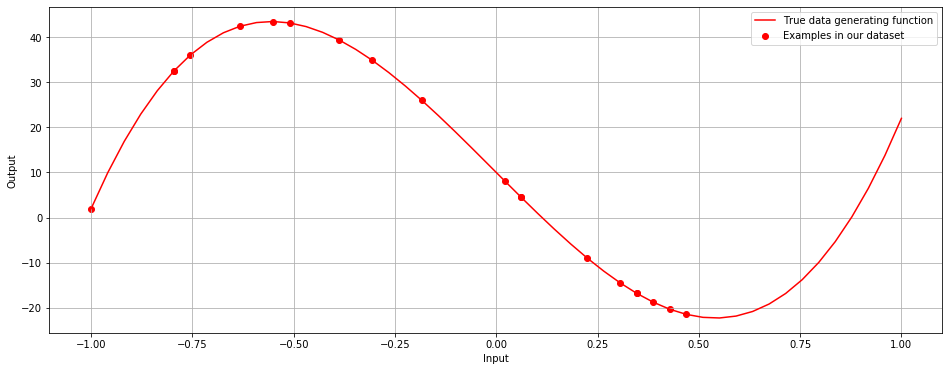

In [1]:
import torch
from torchvision import datasets, transforms
import numpy
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import numpy as np

_range = 1
all_possible_inputs = np.linspace(-_range, _range, 50) # create a range of inputs 
m = 20 # how many examples do we want?
dataset = np.random.choice(all_possible_inputs, size=(m,)) # here we randomly sample some inputs from the true data
true_coeffs = (10, -90, 2, 100) # coefficients of our data generating function
Y_fn = np.polynomial.polynomial.Polynomial(true_coeffs) # create a polynomial data generating function with these coefficients
Y = Y_fn(dataset) # evaluate our data generating function on these inputs

fig = plt.figure(figsize=(16, 6))
plt.scatter(dataset, Y, c='r', label='Examples in our dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's split our dataset into training and testing sets 

PyTorch is a Python library that we will cover in MUCH more detail [later](). 
It has a utility method `torch.utils.data.random_split()` that makes it easy to randomly split a dataset. 
The first argument is the dataset that you want to split.
The second argument it a list of the sizes of each output dataset.
The sum of the sizes in this list must be equal to the length of the dataset that you are splitting.
You can split the input dataset into more than just 2 by providing more than 2 sizes in the second argument.
Check out the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) here.

len total dataset: 20
len train_set: 15
len test_set: 5


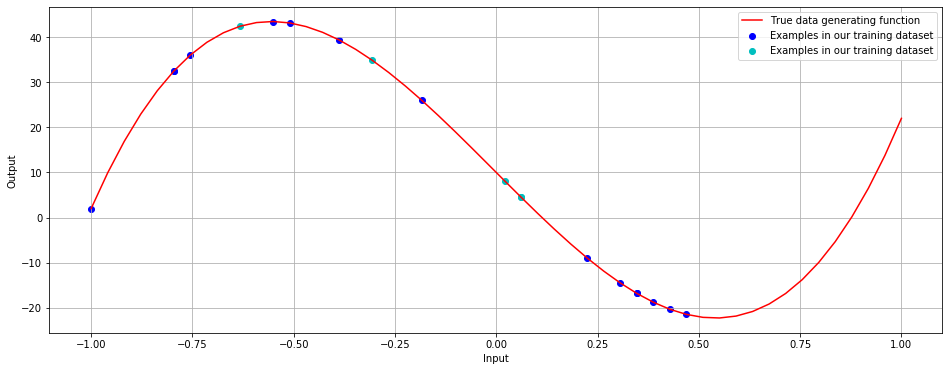

In [2]:
print('len total dataset:', len(dataset))

train_data, test_data,  = torch.utils.data.random_split(dataset, [15, 5]) # randomly split data into train and validation sets

print('len train_set:', len(train_data))
print('len test_set:', len(test_data))

plt.figure(figsize=(16, 6))
plt.scatter(train_data, Y_fn(train_data), c='b', label='Examples in our training dataset')
plt.scatter(test_data, Y_fn(test_data), c='c', label='Examples in our training dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's train a polynomial model that performs multivariate regression and test it's performance.

The code below creates a polynomial model of the form:

## $y = b + w_1 x + w_2 x^2 + ... + w_n x^n$

The loss function which it optimises is the mean squared error loss function regularised with weight decay:

## $L = \frac{1}{m}\sum_{i=1}^m(\hat{y} - y)^2 + \lambda \sum_{i=1}^m w_i^2$

where $\lambda$ is the weight decay parameter and $w_i$ is the ith weight of the model not including the bias, $b$.

We've done this before, so just run the cell below.

TEST LOSS: 1.275452668321575


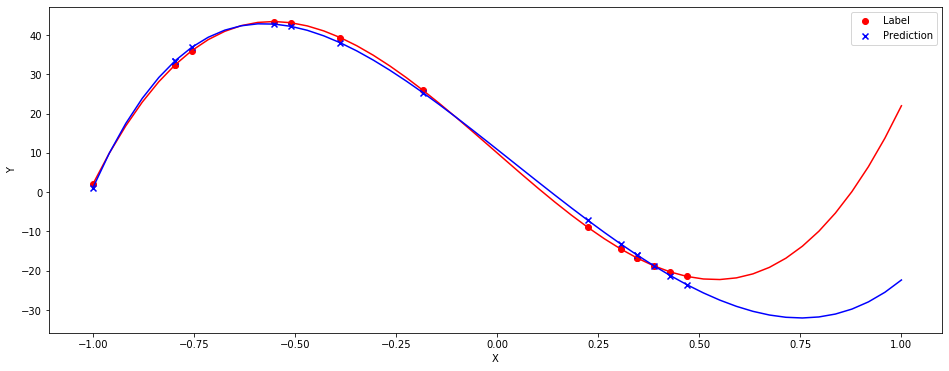

In [3]:
class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn()
        self.w = np.random.randn(n_features)
    def __call__(self, X): #input is of shape (n_datapoints, n_vars)
        y_hat = np.matmul(X, self.w) + self.b
        return y_hat #output is of shape (n_datapoints, 1)
    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
    def calc_deriv(self, X, y_hat, labels):
        diffs = y_hat - labels # calculate error
        dLdw = 2 * np.array([np.sum(diffs * X[:, i]) / m for i in range(self.n_features)]) # derivative of MSE term of loss 
        dLdw += 2 * weight_decay * self.w # add derivative of weight decay term of loss                      
        dLdb = 2 * np.sum(diffs) / m
        return dLdw, dLdb
            
def train(num_epochs, X, Y, H, weight_decay):
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
        
def test(X, Y, H):
    y_hat = H(X) # make predictions
    loss = np.sum((y_hat - Y)**2) / len(Y) # calculate mean squared error
    loss += weight_decay * np.dot(H.w, H.w)
    return loss
                           
def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([X, *[np.power(X, i) for i in range(2, order + 1)]]).T
    return new_dataset # new_dataset should be shape [m, order]

num_epochs = 10000
learning_rate = 0.1
highest_order_power = 5 # change this to adjust the model
weight_decay = 0

X_train = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs from train data
Y_train = Y_fn(train_data)
H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    
train(num_epochs, X_train, Y_train, H, weight_decay) # train model and plot cost curve

X_test = create_polynomial_inputs(test_data, highest_order_power) # create polynomial inputs from train data
Y_test = Y_fn(test_data)
loss = test(X_test, Y_test, H)
print('TEST LOSS:', loss)

fig = plt.figure(figsize=(16, 6))
plt.scatter(train_data, Y_fn(train_data), c='r', label='Label')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r')
plt.scatter(train_data, H(X_train), c='b', label='Prediction', marker='x')
plt.plot(all_possible_inputs, H(create_polynomial_inputs(all_possible_inputs, highest_order_power)), c='b')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Run `tensorboard --logdir=runs` in your terminal to start tensorboard. Then run the cell below to get some data, create training and test data loaders, train a neural network on the test set and plot its loss on to tensorboard (see this by visiting tensorboard at [localhost:6006](http://localhost:6006)).

Within Tensorboard you should be able to see the nice looking loss curve (once you've started it from your terminal).

## Hyperparameters

You've probably already asked questions along the lines of "What's the best weight decay coefficient?", "What batch size should I use?", "What learning rate should I use?", "What polynomial terms should my model include?".

The batch size, learning rate and model architecture are all examples of **hyperparameters**. They are not optimised by the learning algorithm itself.

Most commonly, a parameter is chosen to be a hyperparameter becuase optimising this parameter on the training set is not appropriate. For example, the number of polynomial terms in a model is a hyperparameter. This is because a model with more polynomial terms means a model with greater capacity. So if optimised directly, the optimal value is as large as possible. This would lead to the model overfitting. As such, any parameters that control the capacity of a model should be hyperparameters. Similarly, the weight decay coefficient is a capacity controlling hyperparameter.

Other times, a parameter may be chosen to be a hyperparameter if is challenging to optimise. For example, the batch size. The batch size is challenging to optimise because you will need to fully train and test many different models to compare how changing it affects the final loss on the test set.

## Why should we not tune our hyperparameters based on our model's score on the test set?

Previously we have split our data into train and test sets. The test set is for estimating how well our model  will generalise to perform well on unseen examples. It is important that we do not use the test set to make any decisions about the model. If we do, our model would be overfit to the test set because we are both training and testing our hyperparameters on the test data.

You may find that a certain set of hyperparameters perform well on the test set, but then fail to perform as well in the wild when the model is being evaluated on other unseen examples because the hyperparameters that you selected were optimised for *this* test data. 

## What else can we tune them on? 

Just like we previously split our data into train and test sets. We can split our train set into a final train set and **validation set**. 

We can then use this split-off validation dataset to validate that the current hyperparameters will make our model to perform well on unseen data - both the validation set and the test set are unseen.


In [4]:
print('len of initial train set', len(train_data))
train_data, val_data,  = torch.utils.data.random_split(train_data, [8, 7]) # randomly split data into train and validation sets

print('len of remaining train_set:', len(train_data))
print('len val_set:', len(val_data))

X_val = create_polynomial_inputs(val_data, highest_order_power) # create polynomial inputs from train data
Y_val = Y_fn(val_data)

def validate(X, Y, H):
    y_hat = H(X) # make predictions
    loss = np.sum((y_hat - Y)**2) / len(Y) # calculate mean squared error
    loss += weight_decay * np.sum(H.w**2) # add weight decay term to loss
    return loss

len of initial train set 15
len of remaining train_set: 8
len val_set: 7


## Let's implement a grid search to optimise our hyperparameters

In [5]:
# HERE ARE SOME HYPERPARAMETERS THAT WE WILL OPTIMISE
weight_decays = list(np.linspace(0, 0.001, 10))
highest_order_powers = list(range(1, 10))

losses = np.zeros((len(weight_decays), len(highest_order_powers)))
for pow_idx, highest_order_power in enumerate(highest_order_powers):
    
    X_train = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs
    Y_train = Y_fn(train_data)
    
    X_val = create_polynomial_inputs(val_data, highest_order_power) # create polynomial inputs
    Y_val = Y_fn(val_data)
    
    H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    for wd_idx, weight_decay in enumerate(weight_decays):
        train(num_epochs, X_train, Y_train, H, weight_decay)
        loss = validate(X_val, Y_val, H) # validate
#         print(f'Weight_decay: {weight_decay}\t\tHighest order power: {highest_order_power}\t\tLoss: {loss}')
        losses[wd_idx][pow_idx] = loss

Run the cell below to visualise these parameterisations in 3d.

In [6]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

norm = plt.Normalize(losses.min(), losses.max())
colors = cm.viridis(norm(losses))
rcount, ccount, _ = colors.shape

%matplotlib

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
best_params = np.unravel_index(losses.argmin(), losses.shape)
print(losses)
print('best:', best_params)
best_wd = weight_decays[best_params[0]]
best_p = highest_order_powers[best_params[1]]
print('best weight decay:', best_wd)
print('best power:', best_p)
ax.plot([best_wd, best_wd], [best_p, best_p], [0, losses.max()], c='#ff822e', label='Optimal hyperparameters')
lrs, pows = np.meshgrid(highest_order_powers, weight_decays)
print(lrs.shape)
print(pows.shape)
print(losses.shape)
s = ax.plot_surface(pows, lrs, losses, cmap=cm.copper, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
ax.set_xlabel('Weight decay parameter')
ax.set_ylabel('Highest order power')
ax.set_zlabel('Loss')
plt.legend()
plt.show()

Using matplotlib backend: GTK3Agg
[[430.59188664 125.61558554  31.73441027  15.94074186  19.58579264
   43.11023972  81.53412564 121.43480634 176.2348785 ]
 [430.46117204 125.73256409  25.06463278  11.64621688  19.03206351
   44.0182681   83.21864389 119.88140813 166.18472357]
 [430.3313129  126.38018073  26.66262769  12.07618174  17.97662212
   40.90011932  76.94383658 111.07919439 150.58031736]
 [430.20230516 127.51182283  32.49346758  14.91920632  16.93511652
   36.67050002  68.97398998 102.23231116 138.71446826]
 [430.07414475 129.05228537  39.60253256  18.73969211  16.73601072
   33.34147085  62.51568693  95.50415686 131.24861847]
 [429.94682763 130.93741307  46.31049157  22.54807492  17.20991056
   31.06265059  57.66629136  90.12300144 125.64771077]
 [429.82034978 133.11236137  52.17034076  25.97808471  18.0077459
   29.46342492  53.80470267  85.26595254 120.27844373]
 [429.69470722 135.53014825  57.34667118  29.06712028  18.9649848
   28.29040198  50.54941463  80.69864163 114.81

## Summary
- hyperparameters are parameters of our algorithm that don't make sense to optimise directly
    - either because they are difficult to optimise because they need to be tested across many different trained models
    - or because they 
- a validation set is another subset of our whole dataset alongside our training and test sets
- hyperparameters can be tuned by evaluating performance on the validation set because this tests their generalisation without biasing performance, which would be evaluated on the test set
- hyperparameters should not be tuned on the test set because this is prone to overfitting

### Next steps
- [Maximum Likelihood Estimation]

### Challenges
- Implement a genetic hyperparameter search